In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


#### Import libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import itertools

2021-09-19 20:30:51.850957: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


#### Load and inspeact data

In [3]:
train_path = '/kaggle/input/nlp-getting-started/train.csv'
test_path = '/kaggle/input/nlp-getting-started/test.csv'
sub_path = '/kaggle/input/nlp-getting-started/sample_submission.csv'

In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#### Data Preprocessing

##### Drop all null colunms

In [7]:
train_df = train_df.drop(columns=['keyword', 'location'])
test_df = test_df.drop(columns=['keyword', 'location'])

In [8]:
test_df.isnull().sum()

id      0
text    0
dtype: int64

##### Seperate data into featuures and target

In [9]:
train_x = train_df["text"].values
train_y = train_df["target"].values
test_x = test_df["text"].values

##### train-validation split

In [10]:
train_x,valid_x,y_train,y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=1)

##### Word Embeddings

In [11]:
# constants.
max_features = 5000
embedding_dim = 20
sequence_length = 150

#Tokenization
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(train_x)

X_train = tokenizer.texts_to_sequences(train_x)
X_valid = tokenizer.texts_to_sequences(valid_x)
X_test = tokenizer.texts_to_sequences(test_x)

vocab_size = len(tokenizer.word_index) + 1

#pad sequence
X_train = pad_sequences(X_train, padding='post', maxlen=sequence_length)
X_valid = pad_sequences(X_valid, padding='post', maxlen=sequence_length)
X_test = pad_sequences(X_test, padding='post', maxlen=sequence_length)

#### Build Model

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim= vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=sequence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

2021-09-19 20:30:57.478767: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-19 20:30:57.481907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-19 20:30:57.523942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-19 20:30:57.524625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-19 20:30:57.524691: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-19 20:30:57.554463: I tensorflow/stream_executor/platform/def

In [13]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 20)           388480    
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 256)          152576    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 717,889
Trainable params: 717,889
Non-trainable params: 0
__________________________________________________

#### Fit model and compile model

In [14]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_valid, y_valid),
                    validation_steps=20,
                    batch_size=10)


2021-09-19 20:31:00.483696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-19 20:31:00.497330: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000134999 Hz
2021-09-19 20:31:04.278491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-19 20:31:05.031237: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-19 20:31:05.074593: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


In [15]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9849
Validation Accuracy:  0.7505


#### plot train validation error

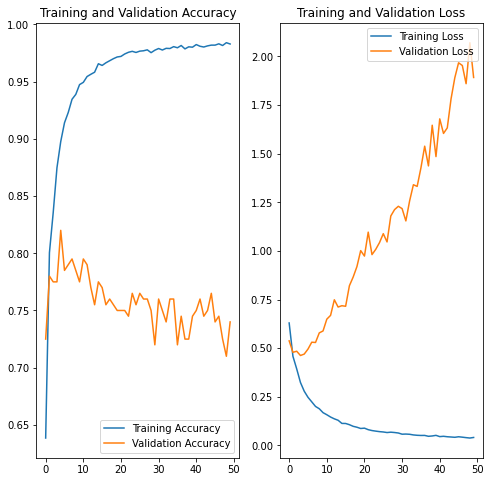

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### predict result

In [17]:
prediction = model.predict_classes(X_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [18]:
predicted_target = list(itertools.chain.from_iterable(prediction.tolist()))

In [19]:
test_predictions= pd.DataFrame({'id': test_df['id'],'target':predicted_target})

In [20]:
test_predictions

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


#### save result

In [21]:
test_predictions.to_csv('my_submission.csv',index=False)